---
numbering:
  enumerator: "4.%s"
---

(chap_data)=
# Data preprocessing

The methods we describe in this chapter are driven by financial applications. For an introduction to non-financial data processing, we recommend two references: chapter 3 from the general purpose ML book by @boehmke2019hands and the monograph on this dedicated subject by @kuhn2019feature.


## Setup and Imports

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Building the data & import functions
from data_build import generate_data
from data_build import plot_conditional_expectations
from data_build import compute_correlations_with_label
from data_build import compute_autocorrelations
data_ml, features, features_short, returns, stock_ids, stock_ids_short = generate_data()
features_short =["Div_yld", "EPS", "Size12m", "Mom_LT", "Ocf", "PB", "Vol_LT"]


## Know your data

The first step, as in any quantitative study, is obviously to make sure the data is trustworthy, i.e., comes from a reliable provider (a minima). The landscape in financial data provision is vast to say the least: some providers are well established (e.g., Bloomberg, Thomson-Reuters, Datastream, CRSP, Morningstar), some are more recent (e.g., Capital IQ, Ravenpack) and some focus on alternative data niches (see https://alternativedata.org/data-providers/ for an exhaustive list). Unfortunately, and to the best of our knowledge, no study has been published that evaluates a large spectrum of these providers in terms of data reliability. 

The second step is to have a look at **summary statistics**: ranges (minimum and maximum values), and averages and medians. Histograms or plots of time series carry of course more information but cannot be analyzed properly in high dimensions. They are nonetheless sometimes useful to track local patterns or errors for a given stock and/or a particular feature.
Beyond first order moments, second order quantities (variances and covariances/correlations)\index{correlation} also matter because they help spot colinearities. When two features are highly correlated, problems may arise in some models (e.g., simple regressions, see Section \@ref(corpred)). 

Often, the number of predictors is so large that it is unpractical to look at these simple metrics. A minimal verification is recommended. To further ease the analysis:

- focus on a subset of predictors, e.g., the ones linked to the most common factors (market-capitalization, price-to-book or book-to-market, momentum (past returns), profitability, asset growth, volatility);   
- track outliers in the summary statistics (when the maximum/median or median/minimum ratios seem suspicious).

Below, in Figure [](#fig-correl_label), we show a box plot that illustrates the distribution of correlations\index{correlation} between features and the one month ahead return. The correlations are computed on a date-by-date basis, over the whole cross-section of stocks. They are mostly located close to zero, but some dates seem to experience extreme shifts (outliers are shown with black circles). The market capitalization has the median which is the most negative while volatility is the only predictor with positive median correlation (this particular example seems to refute the low risk anomaly).


### Boxplot of correlations with the 1M forward return (label)

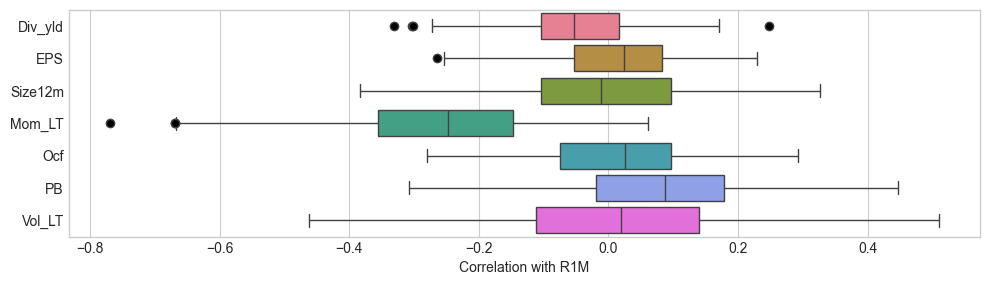

In [83]:
#| label: fig-correl_label
#| fig-cap: "Boxplot of correlations with the 1M forward return (label)."
corr_data = compute_correlations_with_label(data_ml, features_short)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=corr_data, x='correlation', y='Predictor', hue='Predictor', legend=False,
            palette='husl', flierprops={'marker': 'o', 'markerfacecolor': 'black'})
ax.set_xlabel('Correlation with R1M')
ax.set_ylabel('')
ax.set_aspect(0.05)
plt.tight_layout()
plt.show()


More importantly, when seeking to work with supervised learning (as we will do most of the time), the link of some features with the dependent variable can be further characterized by the smoothed **conditional average**\index{conditional average} because it shows how the features impact the label. The use of the conditional average has a deep theoretical grounding. Suppose there is only one feature $X$ and that we seek a model $Y=f(X)+\text{error}$, where variables are real-valued. The function $f$ that minimizes the average squared error $\mathbb{E}[(Y-f(X))^2]$ is the so-called regression function (see Section 2.4 in @friedman2009elements):

```{math}
:label: regfun
f(x)=\mathbb{E}[Y|X=x].
```

In Figure \@ref(fig:regfun), we plot two illustrations of this function when the dependent variable ($Y$) is the one month ahead return. The first one pertains to the average market capitalization over the past year and the second to the volatility over the past year as well. Both predictors have been uniformized (see Section \@ref(scaling) below) so that their values are uniformly distributed in the cross-section of assets for any given time period. Thus, the range of features is $[0,1]$ and is shown on the $x$-axis of the plot. The grey corridors around the lines show 95% level confidence interval for the computation of the mean. Essentially, it is narrow when both (i) many data points are available and (ii) these points are not too dispersed.


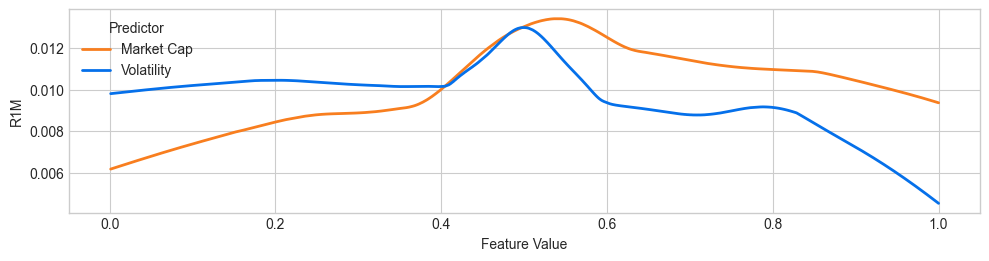

In [84]:
#| label: fig-cond_exp
#| fig-cap: "Conditional expectations: average returns as smooth functions of features."
plot_conditional_expectations(data_ml, ['Size12m', 'Vol_LT'])


The two variables do not have a monotonic impact on future returns. Overall, returns, on average, increase with market capitalization (thereby contradicting the so-called *size* effect). The reverse pattern is observed for volatility: the curve is rather flat for the first half of volatility scores and then decreases, especially over the last quintile of volatility values (thereby corroborating the low-volatility anomaly). 

One important empirical property of features is **autocorrelation**\index{autocorrelation} (or absence thereof). A high level of autocorrelation for one predictor makes it plausible to use simple imputation techniques when some data points are missing. But autocorrelation is also important when moving towards prediction tasks and we discuss this issue shortly below in Section \@ref(pers). In Figure \@ref(fig:histcorr), we build the histogram of autocorrelations, computed stock-by-stock and feature-by-feature.

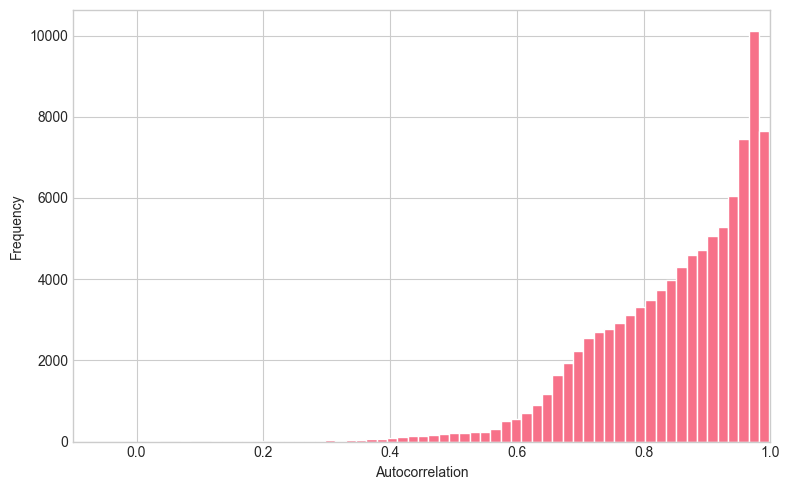

In [85]:
#| label: fig-autocorr
#| fig-cap: "Histogram of feature autocorrelations."

autocorrs = compute_autocorrelations(data_ml, features)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(autocorrs['acf'], bins=60, edgecolor='white')
ax.set_xlim(-0.1, 1)
ax.set_xlabel('Autocorrelation')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Given the large number of values to evaluate, the above chunk is quite time-consuming. The output shows that predictors are highly autocorrelated: most of them have a first order autocorrelation above 0.80.


## Missing data

Similarly to any empirical discipline, portfolio management is bound to face missing data issues. The topic is well known and several books detail solutions to this problem (e.g., @allison2001missing, @enders2010applied, @little2014statistical and @van2018flexible). While researchers continuously propose new methods to cope with absent points (@honaker2010missing or @che2018recurrent to cite but a few), we believe that a simple, heuristic treatment is usually sufficient as long as some basic cautious safeguards are enforced.

First of all, there are mainly two ways to deal with missing data: **removal** and **imputation**. Removal is agnostic but costly, especially if one whole instance is eliminated because of only one missing feature value. Imputation\index{imputation}\index{data imputation} is often preferred but relies on some underlying and potentially erroneous assumption. 

A simplified classification of imputation is the following:

- A basic imputation choice is the median (or mean) of the feature for the stock over the past available values. If there is a trend in the time series, this will nonetheless alter the trend. Relatedly, this method can be forward-looking, unless the training and testing sets are treated separately.    
- In time series contexts with views towards backtesting, the most simple imputation comes from previous values: if $x_t$ is missing, replace it with $x_{t-1}$. This makes sense most of the time because past values are all that is available and are by definition backward-looking. However, in some particular cases, this may be a very bad choice (see words of caution below).  
- Medians and means can also be computed over the **cross-section** of assets. This roughly implies that the missing feature value will be relocated in the bulk of observed values. When many values are missing, this creates an atom in the distribution of the feature and alters the original distribution. One advantage is that this imputation is not forward-looking.    
- Many techniques rely on some modelling assumptions for the data generating process. We refer to nonparametric approaches (@stekhoven2011missforest and @shah2014comparison, which rely on random forests, see Chapter \@ref(trees)), Bayesian imputation (@schafer1999multiple), maximum likelihood approaches (@enders2001primer, @enders2010applied), interpolation or extrapolation and nearest neighbor algorithms (@garcia2009k). More generally, the four books cited at the begining of the subsection detail many such imputation processes. Advanced techniques are much more demanding computationally.    


A few words of caution:   

- Interpolation should be avoided at all cost. Accounting values or ratios that are released every quarter must never be linearly interpolated for the simple reason that this is forward-looking. If numbers are disclosed in January and April, then interpolating February and March requires the knowledge of the April figure, which, in live trading will not be known. Resorting to past values is a better way to go.  
- Nevertheless, there are some feature types for which imputation from past values should be avoided. First of all, returns should not be replicated. By default, a superior choice is to set missing return indicators to zero (which is often close to the average or the median). A good indicator that can help the decision is the persistence of the feature through time. If it is highly autocorrelated (and the time series plot create a smooth curve, like for market capitalization), then imputation from the past can make sense. If not, then it should be avoided.  
- There are some cases that can require more attention. Let us consider the following fictitious sample of dividend yield:

|Date | Original yield | Replacement value|
|--- | --- | ---|
|2015-02 | NA | preceding (if it exists)|
|2015-03 | 0.02 | untouched (none)|
|2015-04 | NA | 0.02 (previous) |
|2015-05 | NA | 0.02 (previous)|
|2015-06 | NA | <= **Problem**!|


In this case, the yield is released quarterly, in March, June, September, etc. But in June, the value is missing. The problem is that we cannot know if it is missing because of a genuine data glitch, or because the firm simply did not pay any dividends in June. Thus, imputation from past value may be erroneous here. There is no perfect solution but a decision must nevertheless be taken. For dividend data, three options are:  

1) Keep the previous value. In R, the function na.locf() from the *zoo* package is incredibly efficient for this task.   
2) Extrapolate from previous observations (this is very different from **inter**polation): for instance, evaluate a trend on past data and pursue that trend.     
3) Set the value to zero. This is tempting but may be sub-optimal due to dividend smoothing practices from executives (see for instance @leary2011determinants and @chen2012dividend for details on the subject). For persistent time series, the first two options are probably better.   

Tests can be performed to evaluate the relative performance of each option. It is also important to **remember** these design choices. There are so many of them that they are easy to forget. Keeping track of them is obviously compulsory. In the ML pipeline, the **scripts** pertaining to data preparation are often key because they do not serve only once!

Finally, we recall that core librairies in python such as [scikit-learn](https://scikit-learn.org/stable/), [pandas](https://pandas.pydata.org/) and [statsmodels](https://www.statsmodels.org/stable/index.html) have functions dedicated to imputation: that deal with data imputation: *SimpleImputer*, *KNNImputer*, *IterativeImputer*, *fillna*. The interested reader can have a look at these. 

Below, we provide example of custom functions that implement the forward-filling and cross-sectional imputation. Note that the latter must be performed on a data-by-date basis. This is to avoid any forward-looking leakage.

In [86]:
def forward_fill_imputation(df, columns):
    """
    Impute missing values using forward fill (previous value).
    Equivalent to R's zoo::na.locf()
    """
    df_imputed = df.copy()
    df_imputed[columns] = df_imputed[columns].ffill()
    return df_imputed

def cross_sectional_median_imputation(df, columns, date_col='date'):
    """
    Impute missing values using cross-sectional median for each date.
    """
    df_imputed = df.copy()
    for col in columns:
        df_imputed[col] = df_imputed.groupby(date_col)[col].transform(
            lambda x: x.fillna(x.median())
        )
    return df_imputed   


## Outlier detection

The topic of outlier detection\index{outlier detection} is also well documented and has its own surveys (@hodge2004survey, @chandola2009anomaly and @gupta2014outlier) and a few dedicated books (@aggarwal2013outlier and @rousseeuw2005robust, though the latter is very focused on regression analysis).

Again, incredibly sophisticated methods may require a lot of efforts for possibly limited gain. Simple heuristic methods, as long as they are documented in the process, may suffice. They often rely on 'hard' thresholds:

- for one given feature (possibly filtered in time), any point outside the interval $[\mu-m\sigma, \mu+m\sigma]$ can be deemed an outlier. Here $\mu$ is the mean of the sample and $\sigma$ the standard deviation. The multiple value $m$ usually belongs to the set $\{3, 5, 10\}$, which is of course arbitrary. 
- likewise, if the largest value is above $m$ times the second-to-largest, then it can also be classified as an outlier (the same reasoning applied for the other side of the tail).
- finally, for a given small threshold $q$, any value outside the $[q,1-q]$ quantile range can be considered outliers.

This latter idea was popularized by **winsorization**.\index{winsorization} Winsorizing amounts to setting to $x^{(q)}$ all values below $x^{(q)}$ and to $x^{(1-q)}$ all values above $x^{(1-q)}$. The winsorized variable $\tilde{x}$ is:
$$\tilde{x}_i=\left\{\begin{array}{ll}
x_i & \text{ if }  x_i \in [x^{(q)},x^{(1-q)}] \quad \text{ (unchanged)}\\
x^{(q)} & \text{ if }  x_i < x^{(q)} \\
x^{(1-q)} & \text{ if }  x_i > x^{(1-q)}
 \end{array} \right. .$$
 
The range for $q$ is usually $(0.5\%, 5\%)$ with 1\% and 2\% being the most often used.

The winsorization stage **must** be performed on a feature-by-feature and a date-by-date basis. However, keeping a time series perspective is also useful. For instance, a $800B market capitalization may seems out of range, except when looking at the history of Apple's capitalization. 

We conclude this subsection by recalling that *true* outliers (i.e., extreme points that are not due to data extraction errors) are valuable because they are likely to carry important information. We also provide two examples for winsorization. 

In [87]:
def winsorize(series, q=0.01):
    lower = series.quantile(q)
    upper = series.quantile(1 - q)
    return series.clip(lower=lower, upper=upper)

def winsorize_by_date(df, columns, date_col='date', q=0.01):
    df_winsorized = df.copy()
    for col in columns:
        df_winsorized[col] = df_winsorized.groupby(date_col)[col].transform(
            lambda x: winsorize(x, q)
        )
    return df_winsorized


## Feature engineering {#feateng}

Feature engineering\index{feature engineering} is a very important step of the portfolio construction process. Computer scientists often refer to the saying "*garbage in, garbage out*". It is thus paramount to prevent the ML engine of the allocation to be trained on ill-designed variables. 
We invite the interested reader to have a look at the recent work of @kuhn2019feature on this topic. The (shorter) academic reference is @guyon2003introduction.

### Feature selection

The first step is selection. It is not obvious to determine which set of predictors to include. For instance, @bali2020cross show that fixed-income related variables do not help to predict equity returns. One heuristic choice is to chose the variables that are often mentioned in the literature (both academic and practical). Though of course, sticking to common characteristics may complicate the generation of alpha because all trading agents will take them into account. Choices can stem from empirical studies such as @chen2021open, or theoretical models like @ohlson1995earnings, which is one of the many papers that justify the inclusion of fundamental values as independent variables in predictive models.


Then, given a large set of predictors, it seems a sound idea to filter out unwanted or redundant exogenous variables. Heuristically, simple methods include:   

- computing the correlation matrix of all features and making sure that no (absolute) value is above a threshold (0.7 is a common value) so that redundant variables do not pollute the learning engine;   
- carrying out a linear regression and removing the non significant variables (e.g., those with $p$-value above 0.05).  
- perform a clustering analysis over the set of features and retain only one feature within each cluster (see Chapter \@ref(unsup)).

Both these methods are somewhat reductive and overlook nonlinear relationships. Another approach would be to fit a decision tree (or a random forest) and retain only the features that have a high variable importance. These methods will be developed in Chapter \@ref(trees) for trees and Chapter \@ref(interp) for variable importance.


### Scaling the predictors {#scaling} 

\index{scaling methods}

The premise of the need to pre-process the data comes from the large variety of scales in financial data:  

- returns are most of the time smaller than one in absolute value;
- stock volatility lies usually between 5% and 80%;
- market capitalization is expressed in million or billion units of a particular currency;
- accounting values as well;
- accounting ratios can have inhomogeneous units;
- synthetic attributes like sentiment also have their idiosyncrasies.


While it is widely considered that monotonic transformations of the features have a marginal impact on prediction outcomes, @galili2016splitting show that this is not always the case (see also Section \@ref(impact-of-rescaling-toy-example)). Hence, the choice of normalization may in fact very well matter.

If we write $x_i$ for the raw input and $\tilde{x}_i$ for the transformed data, common scaling practices include: \index{standardization}

- **standardization**: $\tilde{x}_i=(x_i-m_x)/\sigma_x$, where $m_x$ and $\sigma_x$ are the mean and standard deviation of $x$, respectively;
- **min-max** rescaling over [0,1]: $\tilde{x}_i=(x_i-\min(\mathbf{x}))/(\max(\mathbf{x})-\min(\mathbf{x}))$;
- **min-max** rescaling over [-1,1]: $\tilde{x}_i=2\frac{x_i-\min(\mathbf{x})}{\max(\mathbf{x})-\min(\mathbf{x})}-1$;
- **uniformization**:\index{uniformization} $\tilde{x}_i=F_\mathbf{x}(x_i)$, where $F_\mathbf{x}$ is the empirical c.d.f. of $\mathbf{x}$. In this case, the vector $\tilde{\mathbf{x}}$ is defined to follow a uniform distribution over [0,1].

Sometimes, it is possible to apply a logarithmic transform of variables with both large values (market capitalization) and large outliers. The scaling can come after this transformation. Obviously, this technique is prohibited for features with negative values. 

It is often advised to scale inputs so that they range in [0,1] before sending them through the training of neural networks for instance. The dataset that we use in this book is based on variables that have been uniformized: for each point in time, the cross-sectional distribution of each feature is uniform over the unit interval. In factor investing, the scaling of features must be **operated separately for each date and each feature**. This point is critical. It makes sure that for every rebalancing date, the predictors will have a similar shape and do carry information on the cross-section of stocks. 

Uniformization is sometimes presented differently: for a given characteristic and time, characteristic values are ranked and the rank is then divided by the number of non-missing points. This is done in @freyberger2020dissecting for example. In @kelly2019characteristics, the authors perform this operation but then subtract 0.5 to all features so that their values lie in [-0.5,0.5].

Scaling features across dates should be proscribed. Take for example the case of market capitalization. In the long run (market crashes notwithstanding), this feature increases through time. Thus, scaling across dates would lead to small values at the beginning of the sample and large values at the end of the sample. This would completely alter and dilute the cross-sectional content of the features.  \index{scaling methods}



In [88]:
def norm_unif(v):
    """
    Uniformize a vector using the empirical CDF.
    Values are transformed to follow a uniform distribution over [0,1].
    """
    return stats.rankdata(v, method='average') / len(v)

def norm_0_1(v):
    """
    Min-max rescaling to [0,1] interval.
    """
    v = np.array(v)
    return (v - v.min()) / (v.max() - v.min())

def standardize(v):
    """
    Standardization: (x - mean) / std
    """
    v = np.array(v)
    return (v - v.mean()) / v.std()


## Labelling 
### Simple labels
\index{labelling}
There are several ways to define labels when constructing portfolio policies. Of course, the finality is the portfolio weight, but it is rarely considered as the best choice for the label. Some methodologies do map firm attributes into final weights, e.g., @brandt2009parametric and @ammann2016characteristics, but these are outside the scope of the book. 

Usual labels in factor investing are the following:

- raw asset returns;  
- future relative returns (versus some benchmark: market-wide index, or sector-based portfolio for instance). One simple choice is to take returns minus a cross-sectional mean or median;  
- the probability of positive return (or of return above a specified threshold);  
- the probability of outperforming a benchmark (computed over a given time frame);  
- the binary version of the above: YES (outperforming) versus NO (underperforming);   
- risk-adjusted versions of the above: Sharpe ratios, information ratios, MAR or CALMAR ratios (see Section \@ref(perfmet)).    

When creating binary variables, it is often tempting to create a test that compares returns to zero (profitable versus non profitable). This is not optimal because it is very much time-dependent. In good times, many assets will have positive returns, while in market crashes, few will experience positive returns, thereby creating very unbalanced classes. It is a better idea to split the returns in two by comparing them to their time-$t$ median (or average). In this case, the indicator is relative and the two classes are much more balanced.

As we will discuss later in this chapter, these choices still leave room for additional degrees of freedom. Should the labels be rescaled, just like features are processed? What is the best time horizon on which to compute performance metrics?


### Categorical labels
\index{categorical labels}
In a typical ML analysis, when $y$ is a proxy for future performance, the ML engine will try to minimize some distance between the predicted value and the realized values. For mathematical convenience, the sum of squared error ($L^2$ norm) is used because it has the simplest derivative and makes gradient descent accessible and easy to compute. 

Sometimes, it can be interesting not to focus on raw performance proxies, like returns or Sharpe ratios, but on discrete investment decisions, which can be derived from these proxies. A simple example (decision rule) is the following:

```{math}
:label: catlabel
y_{t,i}=\left\{  \begin{array}{rll}
-1 & \text{ if } & \hat{r}_{t,i} < r_- \\
0 & \text{ if } & \hat{r}_{t,i} \in [r_-,r_+] \\
+1 & \text{ if } & \hat{r}_{t,i} > r_+ \\
\end{array} \right.,
```
where $\hat{r}_{t,i}$ is the performance proxy (e.g., returns or Sharpe ratio) and $r_\pm$ are the decision thresholds. When the predicted performance is below $r_-$, the decision is -1 (e.g., *sell*), when it is above $r_+$, the decision is +1 (e.g., *buy*) and when it is in the middle (the model is neither very optimistic nor very pessimistic), then the decision is neutral (e.g., *hold*). The performance proxy can of course be relative to some benchmark so that the decision is directly related to this benchmark. It is often advised that the thresholds $r_\pm$ be chosen such that the three categories are relatively balanced, that is, so that they end up having a comparable number of instances. 

In this case, the final output can be considered as categorical or numerical because it belongs to an important subgroup of categorical variables: the ordered categorical (**ordinal**) variables.\index{ordinal variable} If $y$ is taken as a number, the usual regression tools apply.


When $y$ is treated as a non-ordered (**nominal**) categorical variable,\index{nominal variable} then a new layer of processing is required because ML tools only work with numbers. Hence, the categories must be recoded into digits. The mapping that is most often used is called '**one-hot encoding**'.\index{one-hot encoding} The vector of classes is split in a sparse matrix in which each column is dedicated to one class. The matrix is filled with zeros and ones. A one is allocated to the column corresponding to the class of the instance. We provide a simple illustration in the table below. 

|Initial data |      | One-hot encoding|     |
|-------------|------|:---------------:|-----|
| Position    | Sell | Hold            | Buy |
| buy         | 0    | 0               | 1   |
| buy         | 0    | 0               | 1   |
| hold        | 0    | 1               | 0   |
| sell        | 1    | 0               | 0   |
| buy         | 0    | 0               | 1   |



In classification tasks,\index{classification} the output has a larger dimension. For each instance, it gives the probability of belonging to each class assigned by the model. As we will see in Chapters \@ref(trees) and \@ref(NN), this is easily handled via the softmax function.


From the standpoint of allocation, handling categorical predictions is not necessarily easy. For long-short portfolios, plus or minus one signals can provide the sign of the position. For long-only portfolio, two possible solutions: (i) work with binary classes (in versus out of the portfolio) or (ii) adapt weights according to the prediction: zero weight for a -1 prediction, 0.5 weight for a 0 prediction and full weight for a +1 prediction. Weights are then of course normalized so as to comply with the budget constraint. 


### The triple barrier method

We conclude this section with an advanced labelling technique mentioned in @de2018advances. The idea is to consider the full dynamics of a trading strategy and not a simple performance proxy. The rationale for this extension is that often money managers implement P&L triggers that cash in when gains are sufficient or opt out to stop their losses. Upon inception of the strategy, three barriers are fixed (see Figure \@ref(fig:triplebarrier)):

- one above the current level of the asset (magenta line), which measures a reasonable expected profit;    
- one below the current level of the asset (cyan line), which acts as a stop-loss signal to prevent large negative returns;   
- and finally, one that fixes the horizon of the strategy after which it will be terminated (black line). 

If the strategy hits the first (*resp*. second) barrier, the output is +1 (*resp*. -1), and if it hits the last barrier, the output is equal to zero or to some linear interpolation (between -1 and +1) that represents the position of the terminal value relative to the two horizontal barriers. Computationally, this method is **much** more demanding, as it evaluates a whole trajectory for each instance. Again, it is nonetheless considered as more realistic because trading strategies are often accompanied with automatic triggers such as stop-loss, etc.


```{figure} images/triple_bar.png
:name: fig-triple_barrier
:align: center
The triple barrier labelling method.
```


### Filtering the sample

\index{filtering training data}
One of the main challenges in Machine Learning is to extract as much **signal** as possible. By signal, we mean patterns that will hold out-of-sample. Intuitively, it may seem reasonable to think that the more data we gather, the more signal we can extract. This is in fact false in all generality because more data also means more noise. Surprisingly, filtering the training samples can improve performance. This idea was for example implemented successfully in @fu2018machine, @guida2019big and @guida2018machine. 

In @coqueret2019training, we investigate why smaller samples may lead to superior out-of-sample accuracy for a particular type of ML algorithm: decision trees (see Chapter \@ref(trees)). We focus on a particular kind of filter: we exclude the labels (e.g., returns) that are not extreme and retain the 20% values that are the smallest and the 20% that are the largest (the bulk of the distribution is removed). In doing so, we alter the structure of trees in two ways:   
- when the splitting points are altered, they are always closer to the center of the distribution of the splitting variable (i.e., the resulting clusters are more balanced and possibly more robust);    
- the choice of splitting variables is (sometimes) pushed towards the features that have a monotonic impact on the label.   
These two properties are desirable. The first reduces the risk of fitting to small groups of instances that may be spurious. The second gives more importance to features that appear globally more relevant in explaining the returns. However, the filtering must not be too intense. If, instead of retaining 20% of each tail of the predictor, we keep just 10%, then the loss in signal becomes too severe and the performance deteriorates. 

### Return horizons {#horizons}

This subsection deals with one of the least debated issues in factor-based machine learning models: horizons. Several horizons come into play during the whole ML-driven allocation workflow: the **horizon of the label**, the **estimation window** (chronological depth of the training samples) and the **holding periods**. One early reference that looks at these aspects is the founding academic paper on momentum by @jegadeesh1993returns. The authors compute the profitability of portfolios based on the returns over the past $J=3, 6, 9, 12$ months. Four holding periods are tested: $K=3,6,9,12$ months. They report: "*The most successful zero-cost (long-short) strategy selects stocks based on their returns over the previous 12 months and then holds the portfolio for 3 months*." While there is no machine learning whatsoever in this contribution, it is possible that their conclusion that horizons matter may also hold for more sophisticated methods. This topic is in fact much discussed, as is shown by the continuing debate on the impact of horizons in momentum profitability (see, e.g., @novy2012momentum, @gong2015momentum and @goyal2015momentum).

This debate should also be considered when working with ML algorithms (see for instance @geertsema2020cross). The issues of estimation windows and holding periods are mentioned later in the book, in Chapter \@ref(backtest). Naturally, in the present chapter, the horizon of the label is the important ingredient. Heuristically, there are four possible combinations if we consider only one feature for simplicity:   

1. oscillating label and feature;   
2. oscillating label, smooth feature (highly autocorrelated);   
3. smooth label, oscillating feature;   
4. smooth label and feature.   
  
Of all of these options, the last one is probably preferable because it is more robust, all things being equal.This is of course not the case for inference relying on linear models. Memory generates many problems and complicates the study of estimators. We refer to @hjalmarsson2011new and @xu2020testing for theoretical and empirical results on this matter. By *all things being equal*, we mean that in each case, a model is capable of extracting some relevant pattern. A pattern that holds between two slowly moving series is more likely to persist in time. Thus, since features are often highly autocorrelated (cf Figure \@ref(fig:histcorr)), combining them with smooth labels is probably a good idea. To illustrate how critical this point is, we will purposefully use 1-month returns in most of the examples of the book and show that the corresponding results are often disappointing. These returns are very weakly autocorrelated while 6-month or 12-month returns are much more persistent and are better choices for labels.

Theoretically, it is possible to understand why that may be the case. For simplicity, let us assume a single feature $x$ that explains returns $r$: $r_{t+1}=f(x_t)+e_{t+1}$. If $x_t$ is highly autocorrelated and the noise embeded in $e_{t+1}$ is not too large, then the two-period ahead return $(1+r_{t+1})(1+r_{t+2})-1$ may carry more signal than $r_{t+1}$ because the relationship with $x_t$ has diffused and compounded through time. Consequently, it may also be beneficial to embed memory considerations directly into the modelling function, as is done for instance in @dixon2020industrial. We discuss some practicalities related to autocorrelations in the next section.


## Handling persistence {#pers}
\index{persistence}
While we have separated the steps of feature engineering and labelling in two different subsections, it is probably wiser to consider them jointly. One important property of the dataset processed by the ML algorithm should be the consistency of persistence between features and labels. Intuitively, the autocorrelation patterns between the label $y_{t,n}$ (future performance) and the features $x_{t,n}^{(k)}$ should not be too distant. 

One problematic example is when the dataset is sampled at the monthly frequency (not unusual in the money management industry) with the labels being monthly returns and the features being risk-based or fundamental attributes. In this case, the label is very weakly autocorrelated, while the features are often highly autocorrelated. In this situation, most sophisticated forecasting tools will arbitrage between features which will probably result in a lot of noise. In linear predictive models, this configuration is known to generate bias in estimates (see the study of @stambaugh1999predictive and the review by @gonzalo2018predictive). 

Among other more technical options, there are two simple solutions when facing this issue: either introduce autocorrelation into the label, or remove it from the features. Again, the first option is not advised for statistical inference on linear models. Both are rather easy econometrically: 

- to increase the autocorrelation of the label, compute performance over longer time ranges. For instance, when working with monthly data, considering annual or biennial returns will do the trick. \index{autocorrelation}    
- to get rid of autocorrelation, the shortest route is to resort to differences/variations: $\Delta x_{t,n}^{(k)}=x_{t,n}^{(k)}-x_{t-1,n}^{(k)}$. One advantage of this procedure is that it makes sense, economically: variations in features may be better drivers of performance, compared to raw levels.

A mix between persistent and oscillating variables in the feature space is of course possible, as long as it is driven by economic motivations. 




## Extensions

### Transforming features
\index{feature transformation}
The feature space can easily be augmented through simple operations. One of them is lagging, that is, considering older values of features and assuming some memory effect for their impact on the label. This is naturally useful mostly if the features are oscillating (adding a layer of memory on persistent features can be somewhat redundant). New variables are defined by $\breve{x}_{t,n}^{(k)}=x_{t-1,n}^{(k)}$.

In some cases (e.g., insufficient number of features), it is possible to consider ratios or products between features. Accounting ratios like price-to-book, book-to-market, debt-to-equity are examples of functions of raw features that make sense. The gains brought by a larger spectrum of features are not obvious. The risk of overfitting increases, just like in a simple linear regression adding variables mechanically increases the $R^2$. The choices must make sense, economically. 

Another way to increase the feature space (mentioned above) is to consider variations. Variations in sentiment, variations in book-to-market ratio, etc., can be relevant predictors because sometimes, the change is more important than the level. In this case, a new predictor is $\breve{x}_{t,n}^{(k)}=x_{t,n}^{(k)}-x_{t-1,n}^{(k)}$. 


### Macro-economic variables {#macrovar}

\index{macro-economic conditioning}
Finally, we discuss a very important topic. The data should never be separated from the context it comes from (its environment). In classical financial terms, this means that a particular model is likely to depend on the overarching situation which is often proxied by macro-economic indicators. One way to take this into account at the data level is simply to multiply the feature by an exogenous indicator $z_{t}$ and in this case, the new predictor is 
\begin{equation}
(\#eq:macrocond)
\breve{x}_{t,n}^{(k)}=z_t \times x_{t,n}^{(k)}
\end{equation}
This technique is used by @gu2018empirical who use 8 economic indicators (plus the original predictors ($z_t=1$)). This increases the feature space ninefold.

Another route that integrates shifting economic environments is conditional engineering. Suppose that labels are coded via formula \@ref(eq:catlabel). The thresholds can be made dependent on some exogenous variable. In times of turbulence, it might be a good idea to increase both $r_+$ (buy threshold) and $r_-$ (sell threshold) so that the labels become more conservative: it takes a higher return to make it to the *buy* category, while short positions are favored. One such example of dynamic thresholding could be 

\begin{equation}
(\#eq:condvix)
r_{t,\pm}=r_{\pm} \times e^{\pm\delta(\text{VIX}_t-\bar{\text{VIX}})},
\end{equation}

where $\text{VIX}_t$ is the time-$t$ value of the VIX, while $\bar{\text{VIX}}$ is some average or median value. When the VIX is above its average and risk seems to be increasing, the thresholds also increase. The parameter $\delta$ tunes the magnitude of the correction. In the above example, we assume $r_-<0<r_+$.
  


### Active learning

\index{active learning}

We end this section with the notion of active learning. To the best of our knowledge, it is not widely used in quantitative investment, but the underlying concept is enlightening, hence we dedicate a few paragraphs to this notion for the sake of completeness.

In general supervised learning, there is sometimes an asymmetry in the ability to gather features versus labels. For instance, it is free to have access to images, but the labelling of the content of the image (e.g., "a dog", "a truck", "a pizza", etc.) is costly because it requires human annotation. In formal terms, $\textbf{X}$ is cheap but the corresponding $\textbf{y}$ is expensive. 

As is often the case when facing cost constraints, an evident solution is greed. Ahead of the usual learning process, a filter (often called *query*) is used to decide which data to label and train on (possibly in relationship with the ML algorithm). The labelling is performed by a so-called *oracle* (which/who knows the truth), usually human. This technique that focuses on the most informative instances is referred to as **active learning**. We refer to the surveys of @settles2009active and @settles2012active for a detailed account of this field (which we briefly summarize below). The term **active** comes from the fact that the learner does not passively accept data samples but actively participates in the choices of items it learns from.

One major dichotomy in active learning pertains to the data source $\textbf{X}$ on which the query is based. One obvious case is when the original sample $\textbf{X}$ is very large and not labelled and the learner asks for particular instances within this sample to be labelled. The second case is when the learner has the ability to simulate/generate its own values $\textbf{x}_i$. This can sometimes be problematic if the oracle does not recognize the data that is generated by the machine. For instance, if the purpose is to label images of characters and numbers, the learner may generate shapes that do not correspond to any letter or digit: the oracle cannot label it.

In active learning, one key question is, how does the learner choose the instances to be labelled? Heuristically, the answer is by picking those observations that maximize learning efficiency. In binary classification, a simple criterion is the probability of belonging to one particular class. If this probability is far from 0.5, then the algorithm will have no difficulty of picking one class (even though it can be wrong). The interesting case is when the probability is close to 0.5: the machine may hesitate for this particular instance. Thus, having the oracle label it is useful in this case because it helps the learner in a configuration in which it is undecided.

Other methods seek to estimate the fit that can be obtained when including particular (new) instances in the training set, and then to optimize this fit. Recalling Section 3.1 in @geman1992neural on the variance-bias tradeoff, we have, for a training dataset $D$ and one instance $x$ (we omit the bold font for simplicity),
$$\mathbb{E}\left[\left.(y-\hat{f}(x;D))^2\right|\{D,x\}\right]=\mathbb{E}\left[\left.\underbrace{(y-\mathbb{E}[y|x])^2}_{\text{indep. from }D\text{ and }\hat{f}} \right|\{D,x\} \right]+(\hat{f}(x;D)-\mathbb{E}[y|x])^2,$$
where the notation $f(x;D)$ is used to highlight the dependence between the model $\hat{f}$ and the dataset $D$: the model has been trained on $D$. The first term is irreducible, as it does not depend on $\hat{f}$. Thus, only the second term is of interest. If we take the average of this quantity, taken over all possible values of $D$:
$$\mathbb{E}_D\left[(\hat{f}(x;D)-\mathbb{E}[y|x])^2  \right]=\underbrace{\left(\mathbb{E}_D\left[\hat{f}(x;D)-\mathbb{E}[y|x]\right]\right)^2}_{\text{squared bias}} \ + \ \underbrace{\mathbb{E}_D\left[(\hat{f}(x,D)-\mathbb{E}_D[\hat{f}(x;D)])^2\right]}_{\text{variance}}$$
If this expression is not too complicated to compute, the learner can query the $x$ that minimizes the tradeoff.\index{variance-bias tradeoff} Thus, on average, this new instance will be the one that yields the best learning angle (as measured by the $L^2$ error). Beyond this approach (which is limited because it requires the oracle to label a possibly irrelevant instance), many other criteria exist for querying and we refer to section 3 from @settles2009active for an exhaustive list.

One final question: is active learning applicable to factor investing? One straightfoward answer is that data cannot be annotated by human intervention. Thus, the learners cannot simulate their own instances and ask for corresponding labels. One possible option is to provide the learner with $\textbf{X}$ but not $\textbf{y}$ and keep only a queried subset of observations with the corresponding labels. In spirit, this is close to what is done in @coqueret2019training except that the query is not performed by a machine but by the human user. Indeed, it is shown in this paper that not all observations carry the same amount of signal. Instances with 'average' label values seem to be on average less informative compared to those with extreme label values. 





## Additional code and results

### Impact of rescaling: graphical representation

We start with a simple illustration of the different scaling methods. We generate an arbitrary series and then rescale it. The series is not random so that each time the code chunk is executed, the output remains the same. 


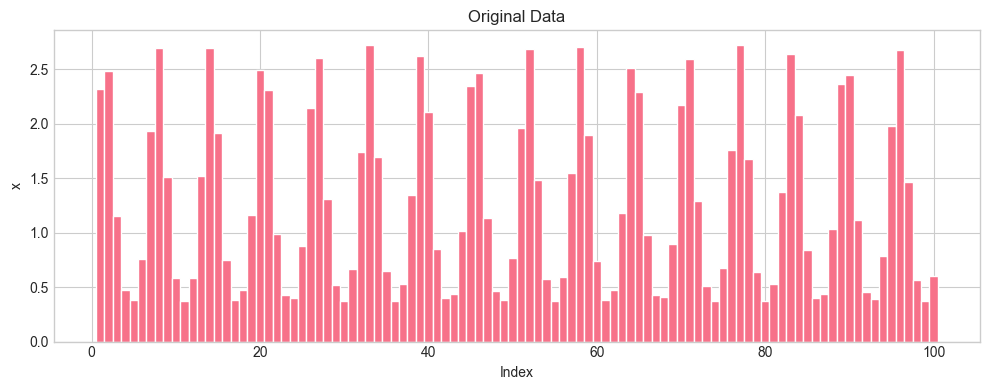

In [89]:
# Generate an arbitrary series
Length = 100
x = np.exp(np.sin(np.arange(1, Length + 1)))

# Create DataFrame with original data
data = pd.DataFrame({
    'index': np.arange(1, Length + 1),
    'x': x
})

# Plot original data
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(data['index'], data['x'], width=1, edgecolor='white')
ax.set_xlabel('Index')
ax.set_ylabel('x')
ax.set_title('Original Data')
plt.tight_layout()
plt.show()

We define and plot the scaled variables below.

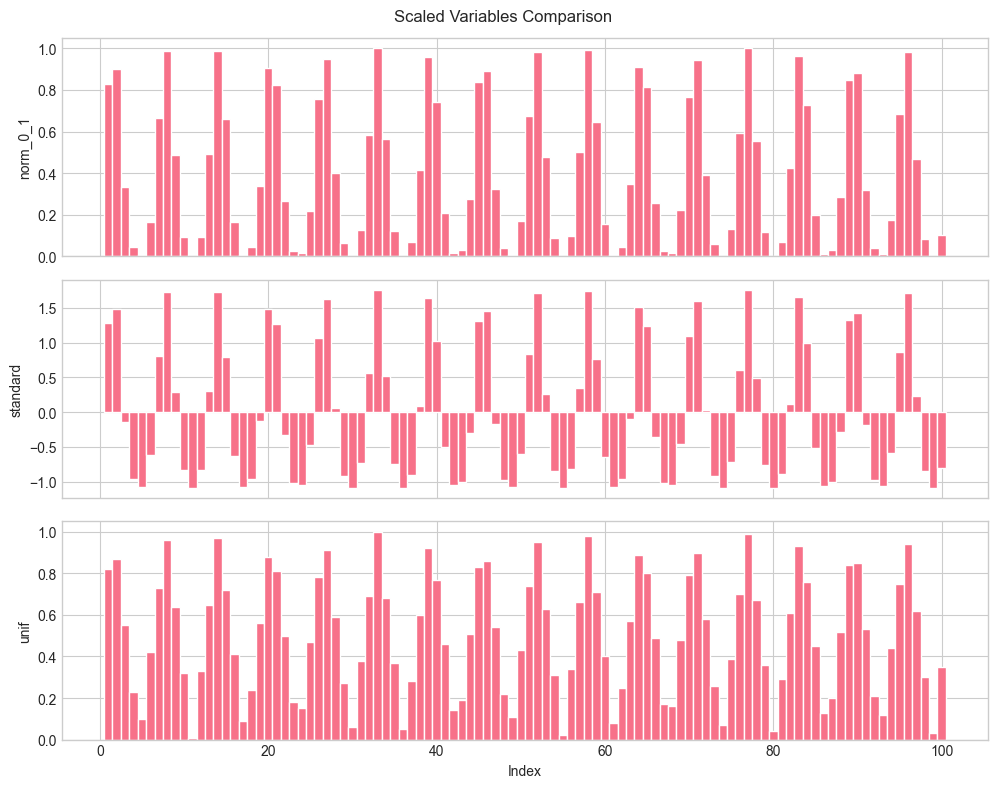

In [90]:
# Compute scaled versions
data_norm = pd.DataFrame({
    'index': np.arange(1, Length + 1),
    'standard': standardize(x),
    'norm_0_1': norm_0_1(x),
    'unif': norm_unif(x)
})

# Melt to long format for plotting
data_norm_long = data_norm.melt(
    id_vars='index',
    var_name='Type',
    value_name='value'
)

# Plot scaled variables
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for ax, (name, group) in zip(axes, data_norm_long.groupby('Type')):
    ax.bar(group['index'], group['value'], width=1, edgecolor='white')
    ax.set_ylabel(name)

axes[-1].set_xlabel('Index')
plt.suptitle('Scaled Variables Comparison')
plt.tight_layout()
plt.show()


Finally, we look at the histogram of the newly created variables.

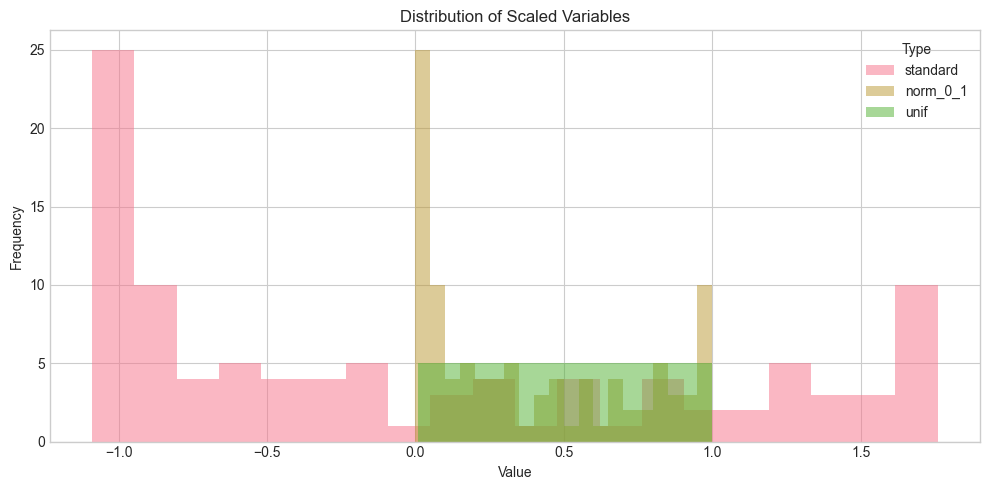

In [91]:
# Histogram of scaled variables
fig, ax = plt.subplots(figsize=(10, 5))

for scaling_type in ['standard', 'norm_0_1', 'unif']:
    ax.hist(data_norm[scaling_type], bins=20, alpha=0.5, label=scaling_type)

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.legend(title='Type')
ax.set_title('Distribution of Scaled Variables')
plt.tight_layout()
plt.show()


With respect to shape, the yellow-ish and red distributions are close to the original one. It is only the support that changes: the min/max rescaling ensures all values lie in the $[0,1]$ interval. In both cases, the smallest values (on the left) display a spike in distribution. By construction, this spike disappears under the uniformization: the points are evenly distributed over the unit interval (green distribution).

### Impact of rescaling: toy example

To illustrate the impact of choosing one particular rescaling method,^[For a more thorough technical discussion on the impact of feature engineering, we refer to @galili2016splitting.] we build a simple dataset, comprising 3 firms and 3 dates. 

In [92]:
# Create toy dataset
firm = [1, 1, 1, 2, 2, 2, 3, 3, 3]
date = [1, 2, 3, 1, 2, 3, 1, 2, 3]
cap = [10, 50, 100, 15, 10, 15, 200, 120, 80]
returns = [0.06, 0.01, -0.06, -0.03, 0.00, 0.02, -0.04, -0.02, 0.00]

data_toy = pd.DataFrame({
    'firm': firm,
    'date': date,
    'cap': cap,
    'return': returns
})

# Apply scaling within each date
data_toy['cap_0_1'] = data_toy.groupby('date')['cap'].transform(norm_0_1)
data_toy['cap_u'] = data_toy.groupby('date')['cap'].transform(norm_unif)

data_toy.round(3)

,firm,date,cap,return,cap_0_1,cap_u
0,1,1,10,0.06,0.000,0.333
1,1,2,50,0.01,0.364,0.667
2,1,3,100,-0.06,1.000,1.000
3,2,1,15,-0.03,0.026,0.667
4,2,2,10,0.00,0.000,0.333
5,2,3,15,0.02,0.000,0.333
6,3,1,200,-0.04,1.000,1.000
7,3,2,120,-0.02,1.000,1.000
8,3,3,80,0.00,0.765,0.667


Let's briefly comment on this synthetic data. We assume that dates are ordered chronologically and far away: each date stands for a year or the beginning of a decade, but the (forward) returns are computed on a monthly basis. The first firm is hugely successful and multiplies its cap ten times over the periods. The second firm remains stable cap-wise, while the third one plummets. If we look at 'local' future returns, they are strongly negatively related to size for the first and third firms. For the second one, there is no clear pattern.

In [93]:
import statsmodels.api as sm

# Regression with min-max rescaled variable
X1 = sm.add_constant(data_toy['cap_0_1'])
model1 = sm.OLS(data_toy['return'], X1).fit()
print("Regression output with min-max rescaling:")
print(model1.summary().tables[1])
print()

Regression output with min-max rescaling:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.014      1.185      0.275      -0.016       0.049
cap_0_1       -0.0497      0.021     -2.326      0.053      -0.100       0.001



In [94]:
# Regression with uniformized variable
X2 = sm.add_constant(data_toy['cap_u'])
model2 = sm.OLS(data_toy['return'], X2).fit()
print("Regression output with uniformization:")
print(model2.summary().tables[1])

Regression output with uniformization:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0600      0.020      3.028      0.019       0.013       0.107
cap_u         -0.1000      0.028     -3.634      0.008      -0.165      -0.035


Note the difference in p-values between the two scaling methods. The standard deviation of `cap_0_1` and `cap_u` are:

- `cap_0_1`: 0.47
- `cap_u`: 0.29

Uniformized variables have reduced dispersion, which can help but is also a double-edged sword.

In [95]:
print(f"Standard deviation of cap_0_1: {data_toy['cap_0_1'].std():.2f}")
print(f"Standard deviation of cap_u: {data_toy['cap_u'].std():.2f}")

Standard deviation of cap_0_1: 0.47
Standard deviation of cap_u: 0.29


## Labelling

### Simple labels

Usual labels in factor investing:
- Raw asset returns
- Future relative returns (versus some benchmark)
- Probability of positive return
- Probability of outperforming a benchmark
- Binary: YES (outperforming) vs NO (underperforming)
- Risk-adjusted versions: Sharpe ratios, information ratios, etc.

### Categorical labels

$$y_{t,i}=\begin{cases}
-1 & \text{if } \hat{r}_{t,i} < r_- \\
0 & \text{if } \hat{r}_{t,i} \in [r_-, r_+] \\
+1 & \text{if } \hat{r}_{t,i} > r_+
\end{cases}$$

In [96]:
def create_categorical_label(returns, r_minus, r_plus):
    """
    Create categorical labels based on return thresholds.
    """
    labels = pd.Series(0, index=returns.index)
    labels[returns < r_minus] = -1
    labels[returns > r_plus] = 1
    return labels

def one_hot_encode(labels):
    """
    One-hot encode categorical labels.
    """
    return pd.get_dummies(labels, prefix='label')

### Dynamic thresholds with VIX conditioning

$$r_{t,\pm} = r_{\pm} \times e^{\pm\delta(\text{VIX}_t - \bar{\text{VIX}})}$$

In [97]:
def dynamic_thresholds(vix_t, vix_mean, r_minus, r_plus, delta=0.1):
    """
    Compute dynamic thresholds based on VIX conditioning.
    """
    adjustment = np.exp(delta * (vix_t - vix_mean))
    return r_minus * adjustment, r_plus * adjustment

## Extensions

### Transforming features

- **Lagging**: $\breve{x}_{t,n}^{(k)} = x_{t-1,n}^{(k)}$
- **Variations**: $\breve{x}_{t,n}^{(k)} = x_{t,n}^{(k)} - x_{t-1,n}^{(k)}$

### Macro-economic conditioning

$$\breve{x}_{t,n}^{(k)} = z_t \times x_{t,n}^{(k)}$$

In [40]:
def add_lagged_features(df, features, id_col='fsym_id', lag=1):
    """
    Add lagged versions of features.
    """
    df_lagged = df.copy()
    for feature in features:
        df_lagged[f'{feature}_lag{lag}'] = df_lagged.groupby(id_col)[feature].shift(lag)
    return df_lagged

def add_feature_variations(df, features, id_col='fsym_id'):
    """
    Add first-difference (variation) versions of features.
    """
    df_diff = df.copy()
    for feature in features:
        df_diff[f'{feature}_diff'] = df_diff.groupby(id_col)[feature].diff()
    return df_diff

def add_macro_conditioned_features(df, features, macro_indicator):
    """
    Add macro-conditioned features: feature * macro_indicator.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset
    features : list
        List of feature column names
    macro_indicator : pd.Series
        Time series of macro indicator (indexed by date)
    """
    df_conditioned = df.copy()
    for feature in features:
        df_conditioned[f'{feature}_macro'] = df_conditioned[feature] * macro_indicator
    return df_conditioned

## Coding exercises

1. The Federal Reserve of Saint Louis (https://fred.stlouisfed.org) hosts thousands of time series of economic indicators that can serve as conditioning variables. Pick one and apply the macro-conditioning formula to expand the number of predictors.

2. Create a new categorical label based on the dynamic VIX threshold formula. The time series of the VIX can be retrieved from: https://fred.stlouisfed.org/series/VIXCLS

3. Plot the histogram of the R12M_Usd variable. Identify the stock with highest value for this variable and determine if the value can be correct or not.